# 6. 나를 찾아줘 - Class Activation Map 만들기

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-1.max-800x600.png)

CAM(Class Activation Map)을 얻기 위한 방법 중 CAM, Grad-CAM을 구현해보고 시각화해보자.   
CAM을 활용해서 물체의 위치를 찾는 object detection을 수행하고 이를 정답 데이터와 비교해보자.

# 6-2. CAM, Grad-CAM용 모델 준비하기(1) 데이터셋 준비하기

CAM은 특성을 추출하는 CNN 네트워크 뒤에 GAP(gloval average pooling)와 softmax layer가 붙는 형태로 구성되어야 한다는 제약이 있다. 하지만 Grad-CAM은 이런 제약이 없다.

CAM, Grad-CAM을 구현해보자.   
CAM은 __클래스에 대한 활성화 정도를 나타낸 지도__이다. 그래서 기본적으로 classification을 수행하는 모델이어야 한다.   
최종 목표는 CAM의 활성화 정도와, 분류 모델의 위치 정보가 기록된 데이터를 비교해야한다.

`tensorflow datasets`의 카탈로그에서 이러한 데이터를 확인할 수 있다. `standford_dogs` 데이터셋을 사용해보자.   
120종의 개 사진을 판별하는 분류 문제 데이터셋으로, 바운딩 박스 정보를 포함하고 있다.

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteK3HZAP/stanford_dogs-train.tfrecord


  0%|          | 0/12000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteK3HZAP/stanford_dogs-test.tfrecord


  0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
슝=3


`tfds.show_examples()`를 통해 각 이미지 클래스와 인덱스를 확인할 수 있다.

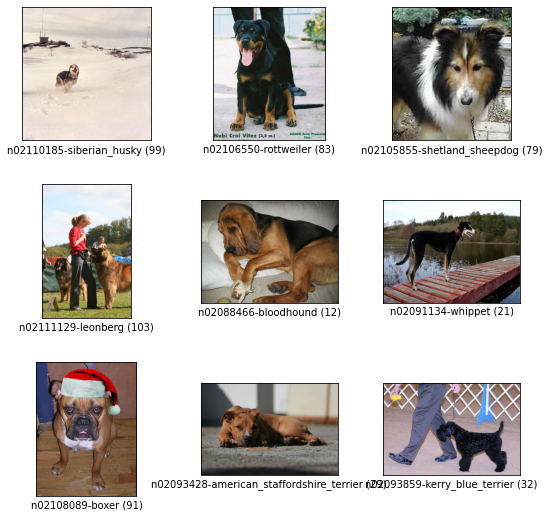

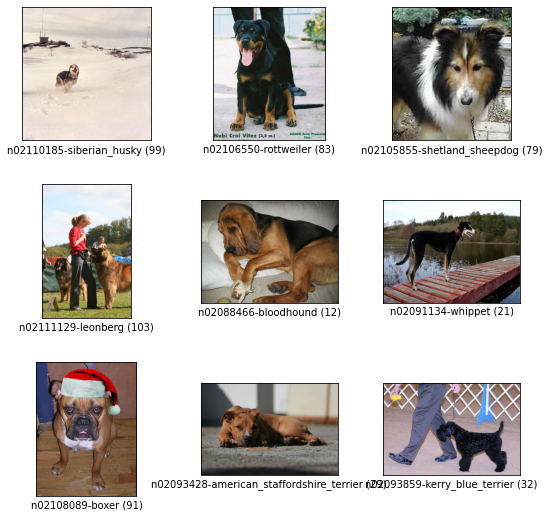

In [ ]:
tfds.show_examples(ds_train, ds_info)

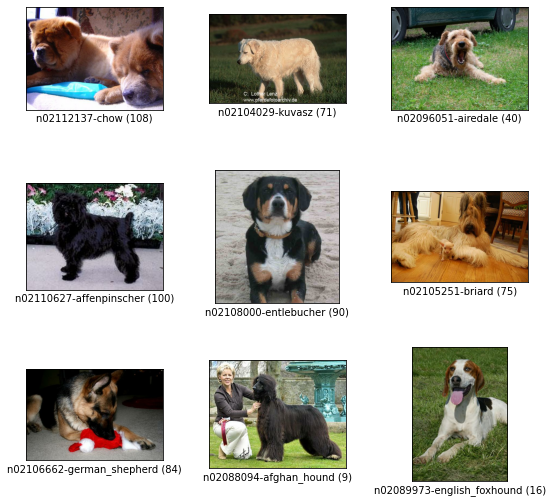

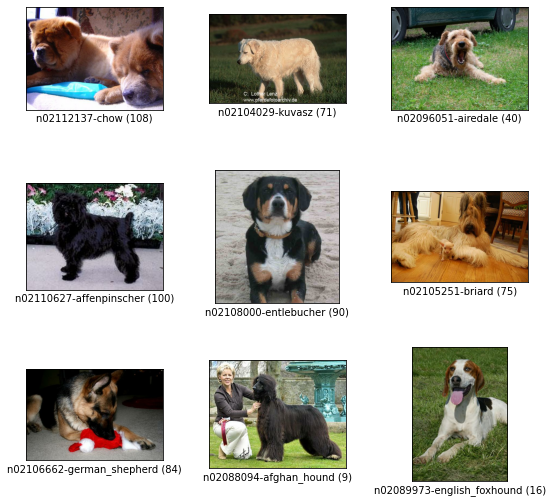

In [ ]:
tfds.show_examples(ds_test, ds_info)

# 6-3. CAM, Grad-CAM용 모델 준비하기(2) 물체의 위치정보

`ds_info`를 사용해서 features의 구성을 살펴보자.

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

`bbox`가 있다. 이는 바운딩 박스이다. `BBoxFeature`이라는 타입으로 정의되어 있다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-3-P-2.jpg)

### 바운딩 박스를 표시하는 방법
바운딩 박스를 라벨링 하는 방법은 다양하게 있다. 알아보자.

- xywh   
바운딩 박스 중심점을 x, y로 표기하고, 사각형의 너비 w와 높이 h를 표기하는 방법이다.   
(x_center, y_center, width, height)   
x, y가 중심점이 아닌 좌측 상단의 점을 가리킬 수 있다.
- mixmax   
바운딩 박스를 이루는 좌표의 최소값과 최대값을 통해 표기하는 방법이다.   
(x_min, x_max, y_min, y_max)   
좌표의 절대값이 아닌, 전체 이미지의 너비와 높이를 기준으로 normalize한 상대적인 값을 표기하는 것이 일반적이다.

위 두가지 뿐만 아니라 이미지의 상하좌우 끝단으로부터 거리로 표현하는 방법, 좌우측의 x값과 상하측의 y값 네 개로 표시하는 LRTB, 네 점의 x, y좌표 값을 모두 표시하는 QUAR등 여러가지 있다.

[BBoxFeature](https://www.tensorflow.org/datasets/api_docs/python/tfds/features/BBoxFeature)

# 6-4. CAM, Grad-CAM용 모델 준비하기(3) CAM을 위한 모델 만들기

CAM을 얻어내기 위한 모델을 만들어보자.   
ImageNet 데이터에 훈련된 ResNet50를 기반으로 pooling layer 뒤에 softmax를 붙여 Grad-CAM 모델을 만들어보자.

softmax layer는 softmax 함수를 activation function으로 사용하는 FC layer이다.

### 구현해보기
ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성하자. 

In [ ]:
num_classes = ds_info.features["label"].num_classes
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
cam_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

여기서 conv5_block3_out의 output이 feature map이 된다.

# 6-5. CAM, Grad-CAM용 모델 준비하기(4) 모델 학습하기

학습을 위한 과정을 정리해보자.

학습 데이터와 검증 데이터에 normalizing과 resizing을 포함한 간단한 전처리를 하고, 이를 포함한 배치를 구성하자.

In [ ]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


CAM 모델은 object detection이나 segmentation에도 활용될 수 있지만, bounding box 같은 직접적인 라벨을 사용하지 않고 weakly supervised learning을 통해 물체 영역을 간접적으로 학습시키는 방법이다.   
그래서 input에 이전과 다르게 `bbox`의 정보가 포함되어 있지만, CAM 모델의 학습에는 필요가 없으므로 `normalize_and_resize_img` 과정에서 제외했다.

In [ ]:
# 데이터셋에 전처리와 배치처리를 적용합니다. 
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_test_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [ ]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_test_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2
750/750 [==============================] - 8410s 11s/step - loss: 2.2238 - accuracy: 0.4435 - val_loss: 3.0020 - val_accuracy: 0.2655
Epoch 2/2
250/750 [=========>....................] - ETA: 1:19:54 - loss: 1.0087 - accuracy: 0.7180

In [ ]:
# import os

# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model1.h5'
# cam_model.save(cam_model_path)
# print("저장 완료!")

주석을 풀면 학습시킨 가중치를 저장할 수 있다.

# 6-6. CAM

지금까지의 내용들을 정리해서 CAM을 생성해보자.

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


학습된 모델에서 CAM을 생성해보자. CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록 하자.

In [ ]:
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

print('슝=3')

슝=3


80


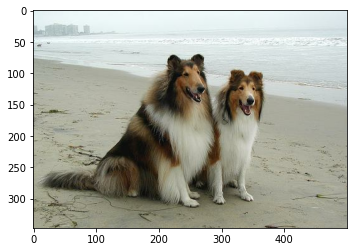

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

아까 학습한 모델을 불러오자.

In [ ]:
# import os
# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
# cam_model = tf.keras.models.load_model(cam_model_path)
# print('슝=3')

CAM을 생성하기 위해 필요한게 있다.   
- 특성 맵
- 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치
- 원하는 클래스의 출력값

이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 시각화해야 한다.   
이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 한다.

In [ ]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    # model.layers[-3].output에서는 우리가 필요로 하는 GAP 이전 Convolution layer의 output을 얻을 수 있습니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0] #마지막 모델의 weight activation을 가져옵니다.
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # W * f 를 통해 class별 activation map을 계산합니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


`conv_outputs`와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현했다.   
마지막은 입력 이미지의 크기에 맞춰 CAM을 resize했다.

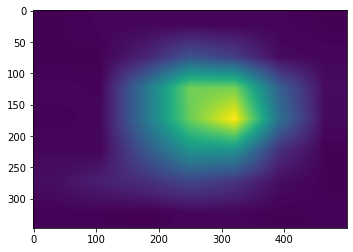

In [ ]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [ ]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    return merged_image

print('슝=3')

슝=3


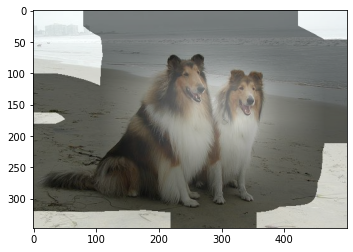

In [ ]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

# 6-7. Grad-CAM

CAM보다 유연한 Grad-CAM을 이용해서 CAM의 결과를 얻어보자.   
모델은 위에서 정의한 `cam_model`을 그대로 활용하자.

67


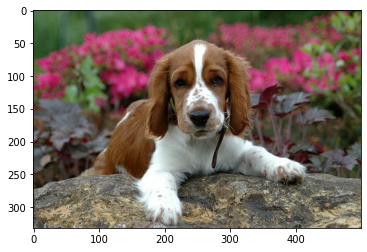

In [ ]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

`grad_cam`은 관찰을 원하는 레이어와 정답 클래스에 대한 예측값 사이의 gradient를 구하고, GAP 연산을 적용함으로써 관찰 대상이 되는 레이어의 채널별 가중치를 구한다.   
최종 CAM 이미지를 구하기 위해 레이어의 채널별 가중치와 레이어에서 나온 채널별 특성 맵을 가중합해주어 cam_image를 얻게 된다.

CAM 함수와 달리, Grad-CAM은 어떤 레이어든 CAM 이미지를 뽑아낼 수 있으므로, gradient 계산을 원하는 관찰 대상 레이어 activation_layer를 받고 뽑아서 쓸 수 있도록 하고 활용해야 한다.

In [23]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 class별 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # 각 class별 weight와 해당 layer의 output을 곱해 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


원하는 레이어의 output과 특정 클래스의 prediction 사이의 grad_val을 얻고 이를 weight로 활용한다.

cam_model.summary() 에서 나온 레이어의 이름을 토대로 CAM 이미지를 뽑아서 확인해보자.

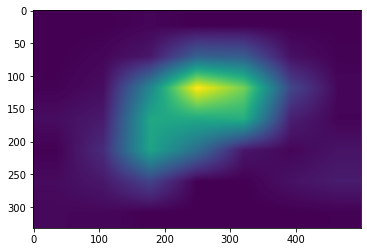

In [24]:
grad_cam_image = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

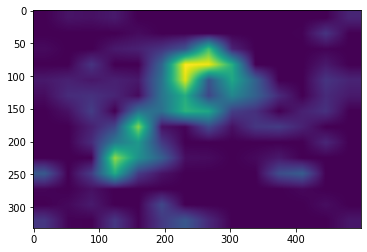

In [25]:
grad_cam_image = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

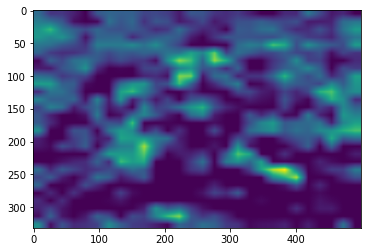

In [26]:
grad_cam_image = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image)
plt.show()

# 6-8. Detection with CAM

### 바운딩 박스
CAM에서 물체의 위치를 찾는 detection을 해보자.

108


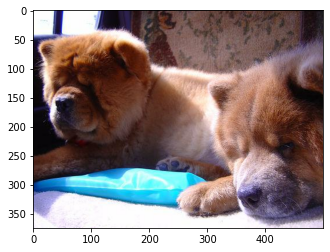

In [27]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

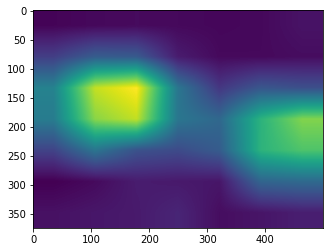

In [28]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

`generate_cam()`을 활용해서 CAM 이미지를 뽑았다.

In [29]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


바운딩 박스를 만들기 위해 `score_thresh`를 받아 역치값 이하의 바운딩 박스는 없앤다. 그 다음 OpenCV의 `findContours()`와 `minAreaRect()`로 사각형을 찾는다.   
이때 `rotated_rect`라는 회전된 바운딩 박스를 얻을 수 있다. `boxPoints()`로 이를 꼭지점으로 바꾸어주고, 마지막에 int형으로 변환했다.

In [30]:
rect = get_bbox(cam_image)
rect

array([[191, 374],
       [191, 306],
       [277, 306],
       [277, 374]])

cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있다.

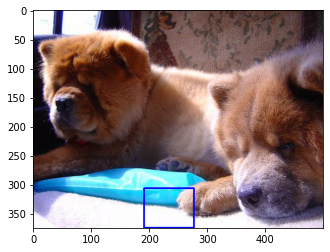

In [31]:
image = copy.deepcopy(item['image'])
image = cv2.drawContours(image, [rect], 0, (0,0,255), 2)
plt.imshow(image)
plt.show()

### Intersection Over Union
CAM, Grad-CAM 두 가지 방법을 통해 바운딩 박스를 얻을 수 있었다. 그러면 정답 데이터인 바운딩 박스와 이를 어떻게 비교, 평가할 수 있을까?

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-3-P-3.max-800x600.jpg)

IoU(Intersection over Union)는 두 영역의 교집합 intersection 영역의 넓이를 두 영역의 합집합 union 영역으로 나누어준 값이다.   
이를 통해 영역을 정확하게 잘 찾아내었는지 상대적인 비율을 구할 수 있고, 모델이 영역을 잘 찾았는지 비교하는 좋은 지표가 된다.

In [32]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


위에서 구한 rect를 bbox 형태로 치환해보자.

In [33]:
pred_bbox = rect_to_minmax(rect, item['image'])
pred_bbox

[0.816, 0.382, 0.9973333333333333, 0.554]

ground truth bbox를 확인해보자.

In [34]:
item['objects']['bbox']

array([[0.13066667, 0.488     , 0.96533334, 0.998     ],
       [0.072     , 0.        , 0.784     , 0.678     ]], dtype=float32)

CAM 추론으로 얻은 bbox와 ground truth bbox가 유사한지 IoU를 계산해서 확인해보자.

In [35]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


In [36]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.022048559748142814

# 6-9. 프로젝트: CAM을 만들고 평가해보자.

- CAM 구현하기
- Grad-CAM 구현하기
- 바운딩 박스 구하기
- IoU 구하기

과정을 진행해보자.